# Data With Geometry

This notebook demonstrates how we can load the geometry of 
geographical locations when we load the data associated with
them just by adding the `with_geoemetry=True` flag to a call
to `censusdis.data.download`.

This is a nice powerful feature because it saves us the time
of loading data and maps separately and dealing with the 
not-quite-matching column names we have to join them on. 
Setting this one flag saves us all that effort.

## Imports and configuration

In [32]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
from censusdis.states import ALL_STATES_DC_AND_PR 
from censusdis import states


## What dataset and variables?

In [2]:
DATASET = "acs/acs5"
YEAR = 2020

In [3]:
# This is a census variable for median household income.
# See https://api.census.gov/data/2020/acs/acs5/variables/B19013_001E.html
MEDIAN_HOUSEHOLD_INCOME_VARIABLE = "B19013_001E"

In [70]:
VARIABLES = ["NAME", 'ucgid', MEDIAN_HOUSEHOLD_INCOME_VARIABLE]

## Shapefile reader

In [5]:
reader = cem.ShapeReader(year=YEAR)

In [6]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[
    gdf_state_bounds["STATEFP"].isin(states.ALL_STATES_AND_DC)
]

## Plot function

In [7]:
plt.rcParams["figure.figsize"] = (18, 8)


def plot_map(
    gdf: gpd.GeoDataFrame,
    geo: str,
    *,
    gdf_bounds: Optional[gpd.GeoDataFrame] = None,
    bounds_color: str = "white",
    max_income: float = 200_000.0,
    **kwargs,
):
    """Plot a map."""
    if gdf_bounds is None:
        gdf_bounds = gdf

    ax = cem.plot_us(gdf_bounds, color="lightgray")

    ax = cem.plot_us(
        gdf,
        MEDIAN_HOUSEHOLD_INCOME_VARIABLE,
        cmap="autumn",
        edgecolor="darkgray",
        legend=True,
        vmin=0.0,
        vmax=max_income,
        ax=ax,
        **kwargs,
    )

    ax = cem.plot_us_boundary(gdf_bounds, edgecolor=bounds_color, linewidth=0.5, ax=ax)

    ax.set_title(f"{YEAR} Median Household Income by {geo.title()}")

    ax.axis("off")

## Query with geography

### Region

In [63]:
gdf_region = ced.download(DATASET, YEAR, VARIABLES, region="*", with_geometry=True)

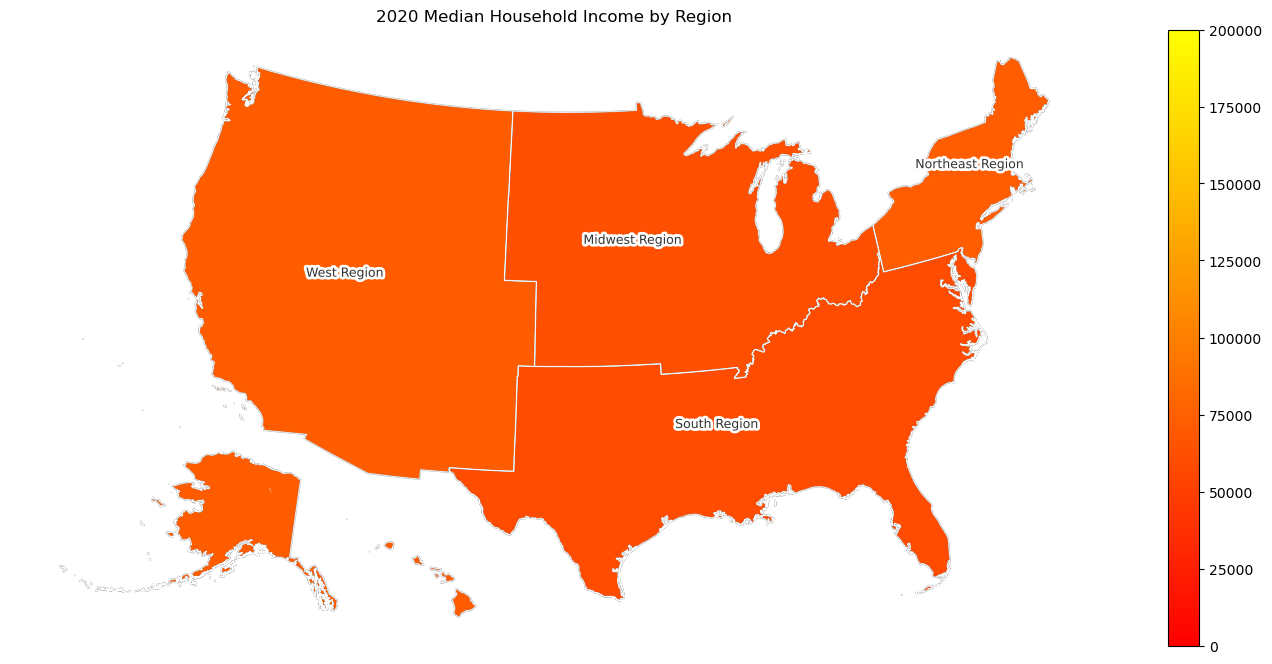

In [9]:
plot_map(gdf_region, "region", geo_label="NAME")

### Division

In [10]:
gdf_division = ced.download(DATASET, YEAR, VARIABLES, division="*", with_geometry=True)

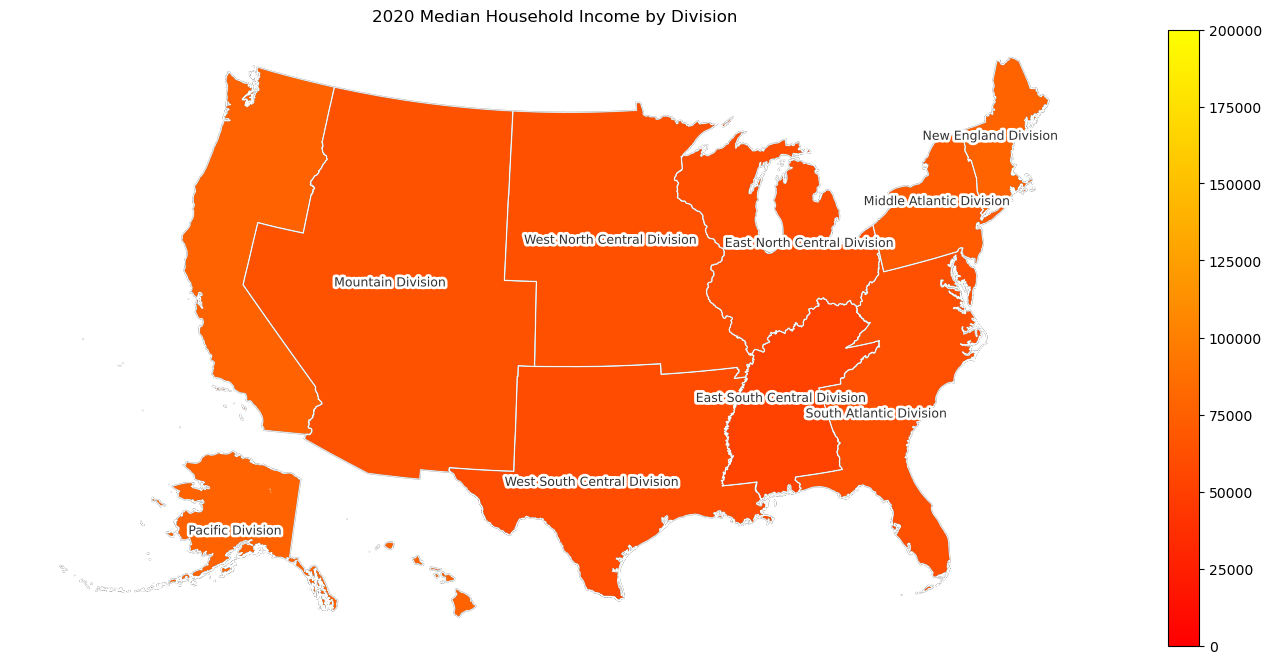

In [11]:
plot_map(gdf_division, "division", geo_label=gdf_division["NAME"])

### State

In [12]:
gdf_state = ced.download(DATASET, YEAR, VARIABLES, state="*", with_geometry=True)


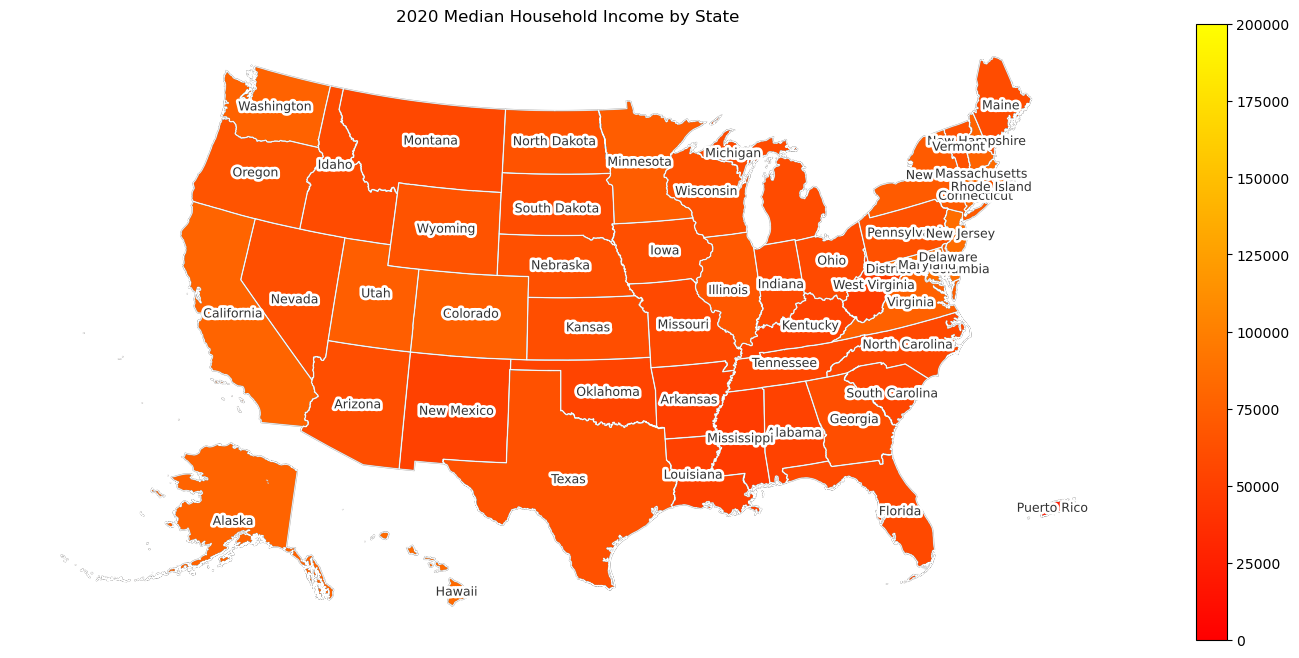

In [13]:
plot_map(gdf_state, "state", geo_label="NAME")

### CBSA

In [14]:
gdf_cbsa = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    metropolitan_statistical_area_micropolitan_statistical_area="*",
    with_geometry=True,
)

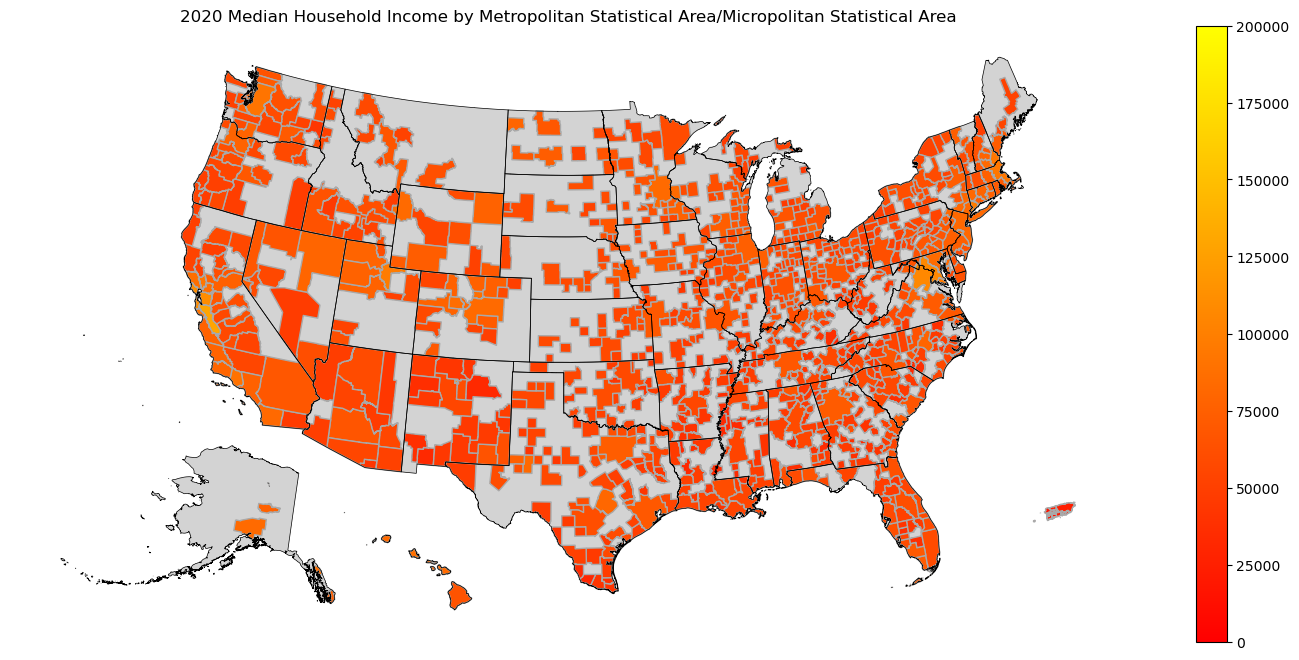

In [15]:
plot_map(
    gdf_cbsa,
    "metropolitan statistical area/micropolitan statistical area",
    gdf_bounds=gdf_state_bounds,
    bounds_color="black",
)

### CSA

In [16]:
gdf_csa = ced.download(
    DATASET, YEAR, VARIABLES, combined_statistical_area="*", with_geometry=True
)

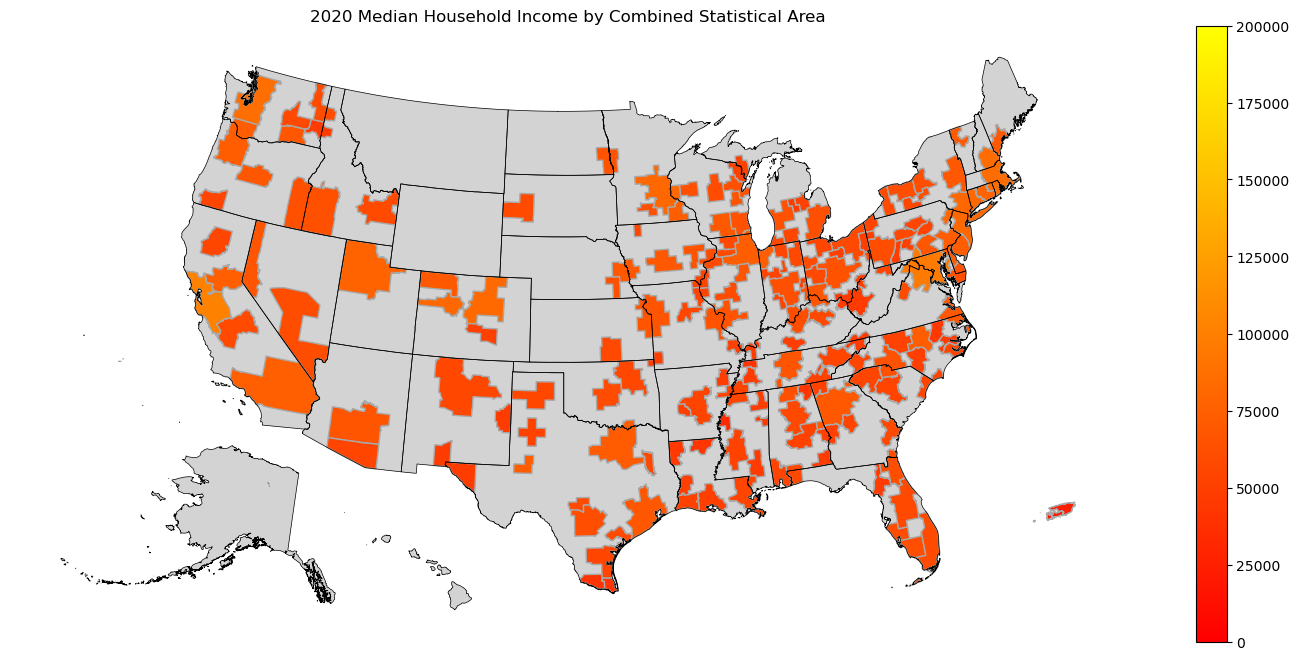

In [17]:
plot_map(
    gdf_csa,
    "combined statistical area",
    gdf_bounds=gdf_state_bounds,
    bounds_color="black",
)

### County

In [18]:
gdf_county = ced.download(
    DATASET, YEAR, VARIABLES, state="*", county="*", with_geometry=True
)

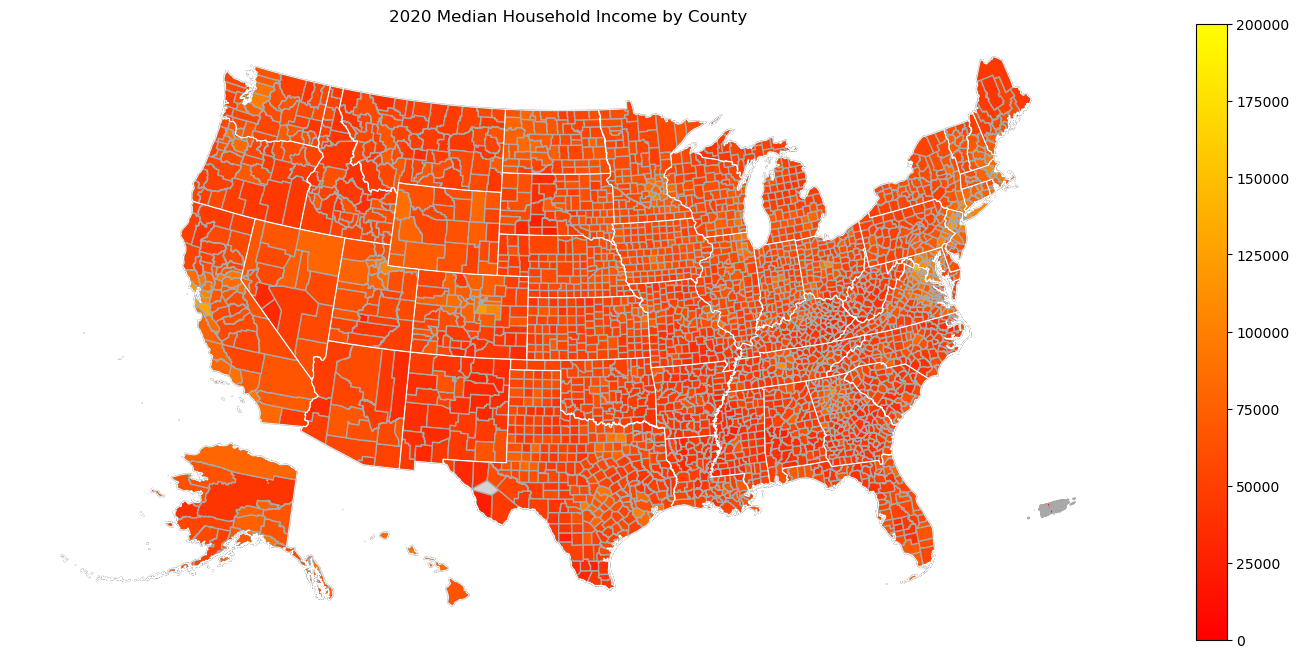

In [19]:
plot_map(gdf_county, "county", gdf_bounds=gdf_state_bounds)

### Census Tract

In [20]:
STATE = states.GA

In [71]:
gdf_tract = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state= ALL_STATES_DC_AND_PR,
    tract="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

CensusApiException: Census API request to https://api.census.gov/data/2020/acs/acs5?get=NAME%2Cucgid%2CB19013_001E&for=tract&in=state%3A01%2C02%2C04%2C05%2C06%2C08%2C09%2C11%2C10%2C12%2C13%2C15%2C16%2C17%2C18%2C19%2C20%2C21%2C22%2C23%2C24%2C25%2C27%2C28%2C26%2C29%2C30%2C31%2C32%2C33%2C34%2C35%2C36%2C37%2C38%2C39%2C40%2C41%2C42%2C44%2C45%2C46%2C47%2C48%2C49%2C50%2C51%2C53%2C54%2C55%2C56%2C72+county%3A%2A failed with status 400. error: error: unknown variable 'ucgid'

<Axes: >

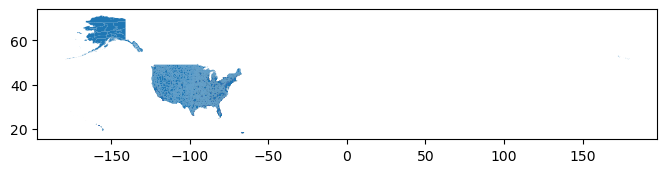

In [34]:
gdf_tract.plot()

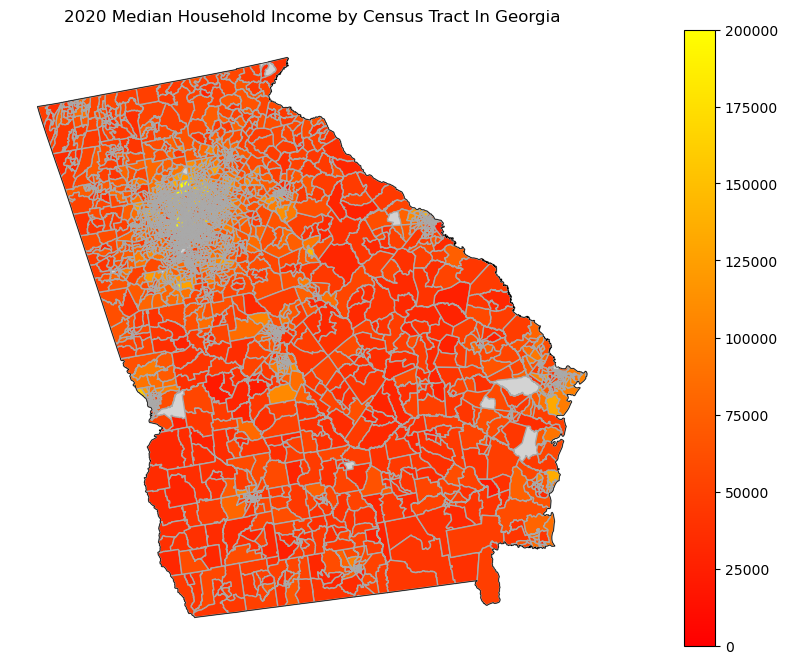

In [22]:
plot_map(
    gdf_tract,
    f"census tract in {states.NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

### Block Group

In [35]:
gdf_bg = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=ALL_STATES_DC_AND_PR,
    block_group="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

gdf_bg["GEOID"] = (
    gdf_bg["state"] +
    gdf_bg["county"] +
    gdf_bg["tract"] +
    gdf_bg["block group"]
)


In [72]:
gdf_bg.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,B19013_001E,geometry
0,29,183,311907,1,"Block Group 1, Census Tract 3119.07, St. Charl...",68807.0,"POLYGON ((-90.75537 38.79583, -90.75473 38.795..."
1,29,183,311908,1,"Block Group 1, Census Tract 3119.08, St. Charl...",107667.0,"POLYGON ((-90.82744 38.78847, -90.82662 38.789..."
2,29,183,312001,1,"Block Group 1, Census Tract 3120.01, St. Charl...",107500.0,"POLYGON ((-90.91867 38.88792, -90.91389 38.888..."
3,29,183,312002,2,"Block Group 2, Census Tract 3120.02, St. Charl...",111800.0,"POLYGON ((-90.90727 38.83859, -90.90660 38.839..."
4,29,183,312094,1,"Block Group 1, Census Tract 3120.94, St. Charl...",92770.0,"POLYGON ((-90.86639 38.85411, -90.86121 38.855..."


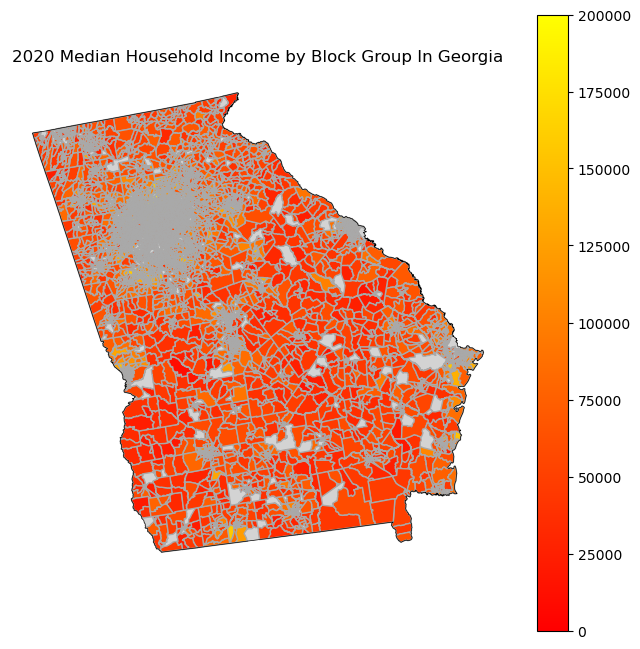

In [24]:
plt.rcParams["figure.figsize"] = (8, 8)

plot_map(
    gdf_bg,
    f"block group in {states.NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

### Congressional District

<Axes: >

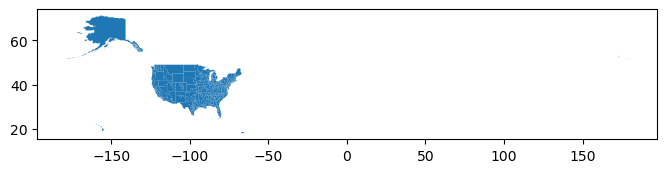

In [37]:
gdf_cd = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=ALL_STATES_DC_AND_PR,
    congressional_district="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)
gdf_cd.plot()

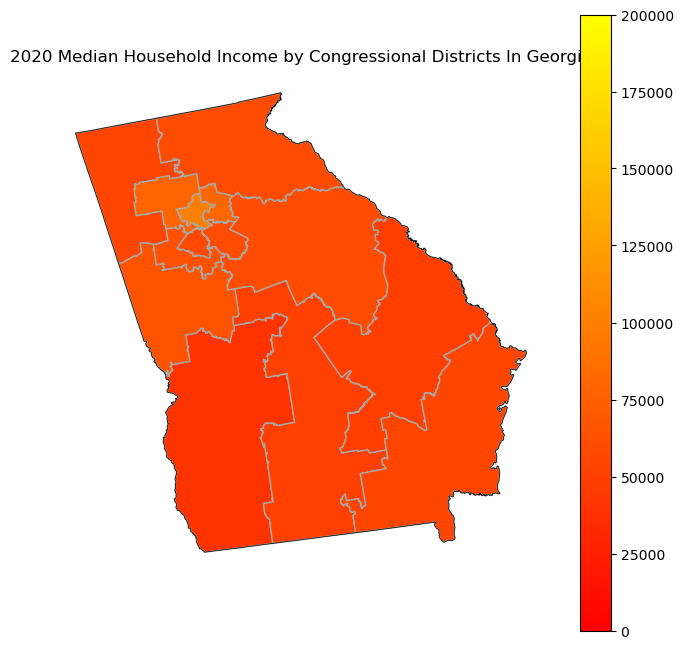

In [26]:
plt.rcParams["figure.figsize"] = (8, 8)

plot_map(
    gdf_cd,
    f"congressional districts in {states.NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

### Public Use Microdata Area

<Axes: >

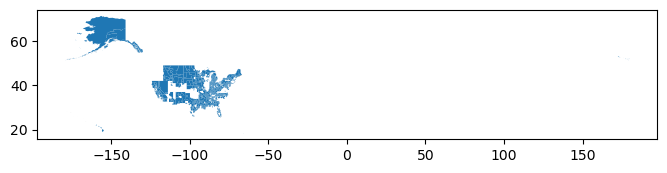

In [38]:
gdf_puma = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=ALL_STATES_DC_AND_PR,
    public_use_microdata_area="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

gdf_puma.plot()

AttributeError: 'NoneType' object has no attribute 'is_empty'

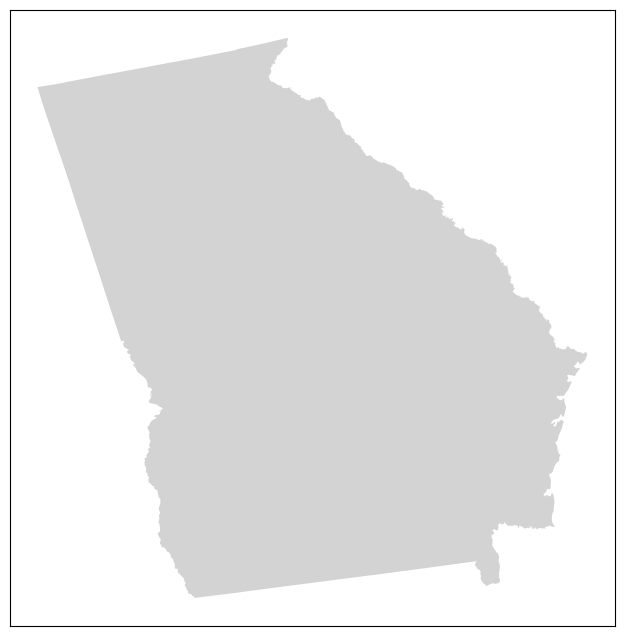

In [45]:
plt.rcParams["figure.figsize"] = (8, 8)

plot_map(
    gdf_puma,
    f"public use microdata area\nin {states.NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

### Delete variables, create geoid and save geometry file

In [102]:
## check gdf columns
# gdf_region.head(1)
# gdf_division.head(1)
# gdf_state.head(1)
# gdf_cbsa.head(1)
# gdf_csa.head(1)
# gdf_county.head(1)
# gdf_tract.head(1)
# gdf_bg.head(1)
# gdf_cd.head(1)

,REGION,NAME,B19013_001E,geometry,GEOID
0,2,Midwest Region,62054,"MULTIPOLYGON (((-82.73447 41.60351, -82.72425 ...",2


In [93]:
# create GEOID column
gdf_region['GEOID'] = gdf_region["REGION"]
gdf_division['GEOID'] = gdf_division["DIVISION"]
gdf_state['GEOID'] = gdf_state["STATE"]
gdf_cbsa['GEOID'] = gdf_cbsa["METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA"]
gdf_csa['GEOID'] = gdf_csa["COMBINED_STATISTICAL_AREA"]
gdf_county['GEOID'] = gdf_county["STATE"] + gdf_county["COUNTY"]
gdf_tract['GEOID'] = gdf_tract['STATE'] + gdf_tract['COUNTY'] + gdf_tract['TRACT']
gdf_bg['GEOID'] = gdf_bg['STATE'] + gdf_bg['COUNTY'] + gdf_bg['TRACT'] + gdf_bg['BLOCK_GROUP']
gdf_cd['GEOID'] = gdf_cd['STATE'] + gdf_cd['CONGRESSIONAL_DISTRICT']

In [106]:
# save to parquet
gdf_region.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/01_region_complex.parquet", engine="pyarrow"
)
gdf_division.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/02_division_complex.parquet", engine="pyarrow"
)
gdf_state.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/03_state_complex.parquet", engine="pyarrow"
)
gdf_cbsa.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/04_cbsa_complex.parquet", engine="pyarrow"
)
gdf_csa.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/05_csa_complex.parquet", engine="pyarrow"
)
gdf_county.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/06_county_complex.parquet", engine="pyarrow"
)
gdf_tract.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/07_tract_complex.parquet", engine="pyarrow"
)
gdf_bg.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/08_bg_complex.parquet", engine="pyarrow"
)
gdf_cd.drop(columns=["B19013_001E"]).to_parquet(
    "../data/processed/geo_complex/09_cd_complex.parquet", engine="pyarrow"
)

In [111]:
# read parquet and check the data
gdf_test = gpd.read_parquet("../data/processed/geo_complex/09_cd_complex.parquet")
gdf_test.head(1)

,STATE,CONGRESSIONAL_DISTRICT,NAME,geometry,GEOID
0,01,01,"Congressional District 1 (116th Congress), Ala...","MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ...",0101


In [117]:
# save to parquet
gdf_region.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/01_region_complex.geojson", driver="GeoJSON"
)
gdf_division.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/02_division_complex.geojson", driver="GeoJSON"
)
gdf_state.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/03_state_complex.geojson", driver="GeoJSON"
)
gdf_cbsa.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/04_cbsa_complex.geojson", driver="GeoJSON"
)
gdf_csa.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/05_csa_complex.geojson", driver="GeoJSON"
)
gdf_county.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/06_county_complex.geojson", driver="GeoJSON"
)
gdf_tract.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/07_tract_complex.geojson", driver="GeoJSON"
)
gdf_bg.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/08_bg_complex.geojson", driver="GeoJSON"
)
gdf_cd.drop(columns=["B19013_001E"]).to_file(
    "../data/processed/geo_complex/09_cd_complex.geojson", driver="GeoJSON"
)